# Langzeitdaten von Home Assistant auswerten
Ersetzt DB Browser nicht, jedoch kann das mit DB Browser entwickelte SQL-Statement mit jupyter notepad gut visualisiert werden.

Zunächst importieren wir die notwendigen Bibliotheken:

In [51]:
import sqlite3 as db
from dateutil import parser
import matplotlib.pyplot as plt
# Für laufenden Mittelwert
import pandas as pd

Um die python-Autovervollständigung zu nutzen muss folgendes "Magic Command" verwendet werden:

In [ ]:
%config Completer.use_jedi = False

Mittels **shift** + **Tab** kann die Hilfe zu einer Funktion aufgerufen werden.
Funktion / Methode muss bereits im Code fertig geschrieben sein, dann kann die Hilfe entsprechend aufgerufen werden.

## Datenbankverbindung herstellen

In [3]:
#connect to database or create if doesn't exist
conn = db.connect('home-assistant_v2.db')

#create cursor
c = conn.cursor()

## Entity-ID herausfinden

In [144]:
c.execute("""
SELECT A.entity_id, A.attributes
FROM (SELECT DISTINCT entity_id, attributes
FROM states
GROUP BY entity_id) AS A
WHERE A.attributes LIKE "%STUD%";
""")
c.fetchall()

[('climate.studio',
  '{"hvac_modes":["heat","off"],"min_temp":16.0,"max_temp":26.0,"target_temp_step":0.1,"preset_modes":["none","away"],"current_temperature":27.5,"temperature":22.5,"hvac_action":"idle","preset_mode":"none","friendly_name":"Studio","supported_features":17}'),
 ('sensor.28_ff5ad9501603_temperature',
  '{"state_class":"measurement","device_file":"/28.FF5AD9501603/temperature","raw_value":27.5625,"unit_of_measurement":"\\u00b0C","device_class":"temperature","friendly_name":"STUD"}'),
 ('switch.29_b20837000000_pio_6',
  '{"device_file":"/29.B20837000000/PIO.6","raw_value":0.0,"friendly_name":"Studio Fenster (38)"}'),
 ('switch.29_b90437000000_pio_5',
  '{"device_file":"/29.B90437000000/PIO.5","raw_value":1.0,"friendly_name":"FBH_STUD"}')]

## Beispiel 1: Studio Temperaturen

In [48]:
#check data in table
c.execute("""
SELECT 'Studio' as sensor, start, mean, min, max 
FROM statistics 
WHERE metadata_id IN (
  SELECT id 
  FROM statistics_meta 
  WHERE statistic_id = 'sensor.28_ff5ad9501603_temperature') 
AND min > -20  AND max < 40
AND start > '2022-01-01'
AND start < '2022-01-20'; --YYYY-MM-DD;""")
data = c.fetchall()
print(data[1])

('Studio', '2022-01-01 01:00:00.000000', 21.599999999999998, 21.6, 21.6)


In [49]:
dates = []
values = []
for row in data:
    dates.append(parser.parse(row[1]))
    values.append(row[2])


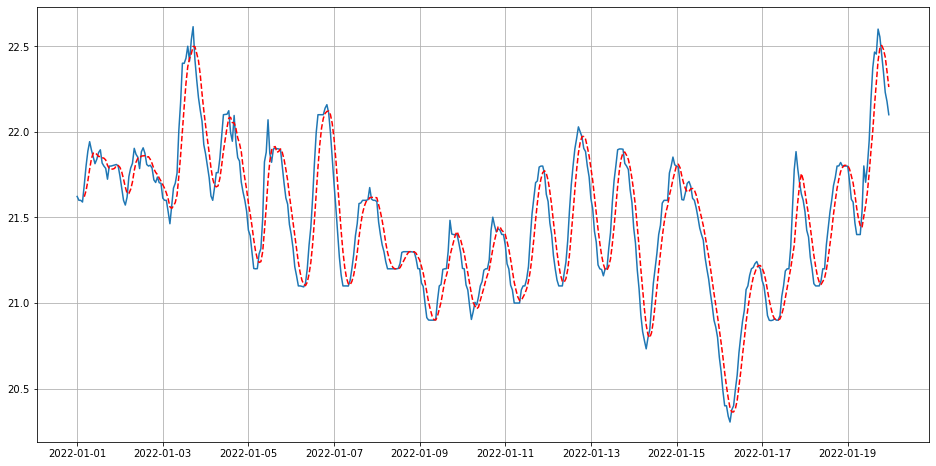

In [55]:
h = plt.figure(figsize=(16, 8))
plt.plot(dates,values,'-')
h.gca().grid()
#plt.show()
temp_series = pd.Series(values)
plt.plot(dates, temp_series.rolling(5).mean(),'r--')

## Beispiel 2: Temperatur und Luftfeuchte in der Garage
Hier wird eine zweite y-Achse für die Luftfeuchtigkeit angelegt. 

In [44]:
#check data in table
c.execute("""
SELECT A.start as Time, A.mean as Temperature, HUMID.mean as Humidity 
FROM
  (SELECT "GarageTemp" as sensor, start, mean, min, max 
   FROM statistics 
   WHERE metadata_id IN (SELECT id FROM statistics_meta WHERE statistic_id = "sensor.26_00003824da00_temperature") 
   AND min > -20 
   AND max < 40) AS A,
  (SELECT start, mean, min, max 
   FROM statistics 
   WHERE metadata_id IN (SELECT id FROM statistics_meta WHERE statistic_id = "sensor.26_00003824da00_humidity_htm1735") 
   AND min > 0 
   AND max < 100) AS HUMID
WHERE
  A.start = HUMID.start
  AND A.start > '2022-01-01'
  AND A.start < '2022-01-20'; --YYYY-MM-DD
""")
data = c.fetchall()
print(data[1])

('2022-01-01 02:00:00.000000', 11.790053729944445, 75.95365424177777)


In [45]:
dates = []
temp = []
humid = []
for row in data:
    dates.append(parser.parse(row[0]))
    temp.append(row[1])
    humid.append(row[2])

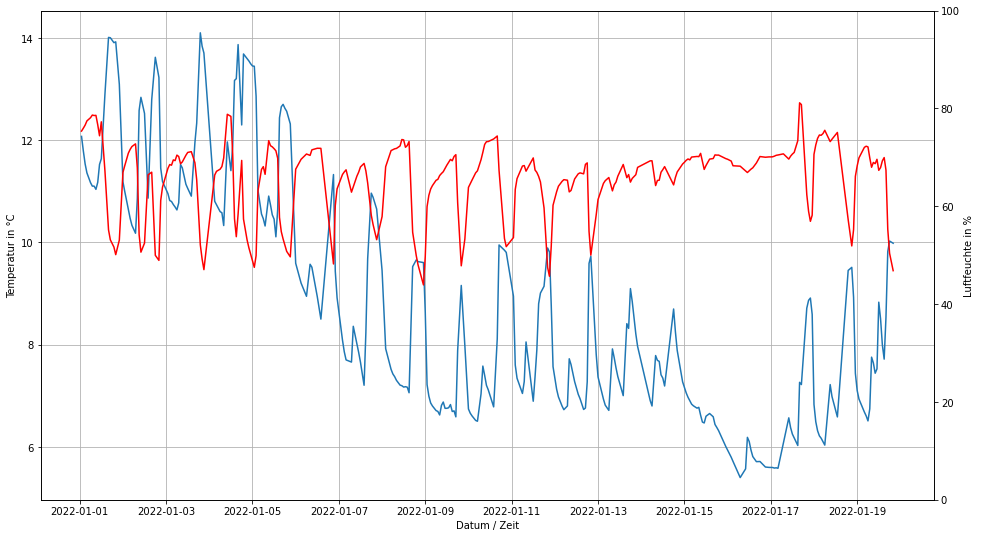

In [46]:
fig, ax1 = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(9)
ax1.grid()
ax1.set_xlabel('Datum / Zeit')
ax1.set_ylabel('Temperatur in °C')
ax1.plot(dates,temp,'-')
#plt.plot_date(dates,humid,'r-')

ax2 = ax1.twinx()
ax2.set_ylabel('Luftfeuchte in %')
ax2.set_ylim(0, 100)
ax2.plot(dates,humid,'r-')

fig.show()
fig.savefig("test.pdf")

## Beispiel 3: Pandas nutzen
Ein schönes getting Started ist auf der [Pandas Webseite](https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html) zu finden

In [115]:
data = pd.read_sql_query("""
SELECT A.start as Time, A.mean as Temperature, HUMID.mean as Humidity 
FROM
  (SELECT "GarageTemp" as sensor, start, mean, min, max 
   FROM statistics 
   WHERE metadata_id IN (SELECT id FROM statistics_meta WHERE statistic_id = "sensor.26_00003824da00_temperature") 
   AND min > -20 
   AND max < 40) AS A,
  (SELECT start, mean, min, max 
   FROM statistics 
   WHERE metadata_id IN (SELECT id FROM statistics_meta WHERE statistic_id = "sensor.26_00003824da00_humidity_htm1735") 
   AND min > 0 
   AND max < 100) AS HUMID
WHERE
  A.start = HUMID.start;
""", conn, parse_dates=["Time"])

# Zeiten selektieren
#data[data["Time"] > "2022-01-18"]

# Index nicht mehr numerisch, sondern das Datetime-Feld nutzen
data = data.set_index('Time')

# Anzeigen
data

,Temperature,Humidity
Time,,
2021-12-09 08:00:00,6.556090,79.500000
2021-12-09 09:00:00,6.563778,79.122437
2021-12-09 10:00:00,6.488567,78.707663
2021-12-09 14:00:00,6.321682,79.092574
2021-12-09 19:00:00,7.230700,83.183896
...,...,...
2022-07-07 07:00:00,21.331798,47.885528
2022-07-07 08:00:00,21.209970,48.793543
2022-07-07 10:00:00,20.900037,51.359934


### Temperaturverlauf mehrerer Monate

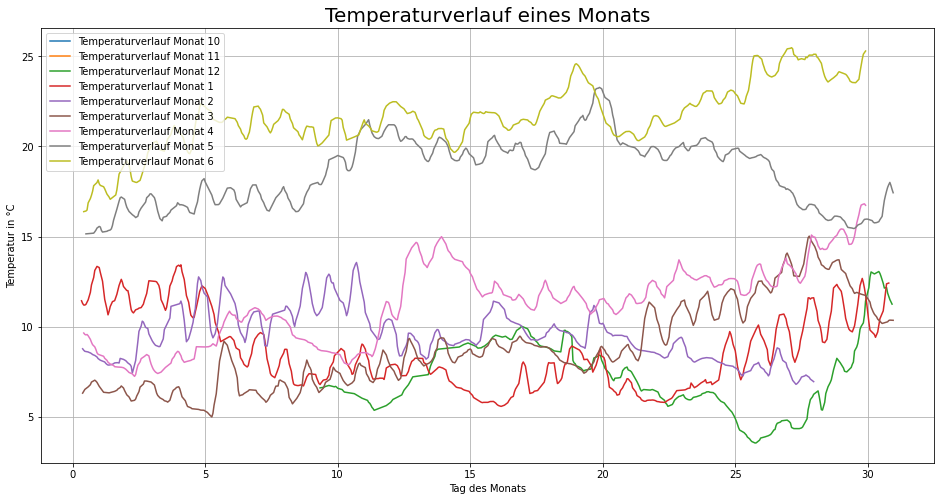

In [112]:
# Ein Jahr / eine Jahresscheibe aus den Daten holen
plotdata = data["2021-10-01":"2022-06-30"]
h = plt.figure(figsize=(16, 8))
ax = h.gca()
ax.grid()
ax.set_title("Temperaturverlauf eines Monats",font='LiberationSans', size=20)
ax.set_xlabel("Tag des Monats")
ax.set_ylabel("Temperatur in °C")
for i in [10,11,12,1,2,3,4,5,6]:
    test = plotdata[plotdata.index.month == i]
    plt.plot(test.index.day - 1 + (test.index.hour)/24.0,test.Temperature.rolling(7).mean(),'-', label="Temperaturverlauf Monat %i" % (i))
plt.legend()

### Einfacher Temperaturverlauf (Zeitraum)

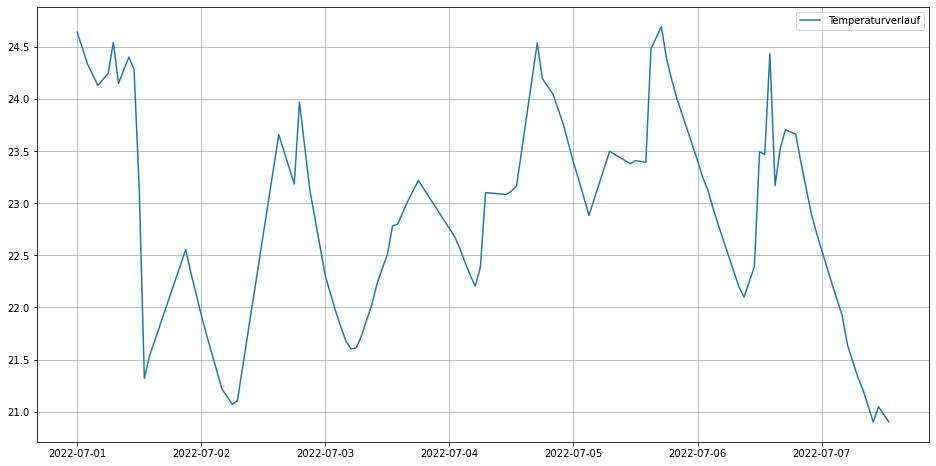

In [88]:
plotdata = data["2022-07-01":"2022-07-07"]

h = plt.figure(figsize=(16, 8))
h.gca().grid()

plt.plot(plotdata.index,plotdata.Temperature,'-', label="Temperaturverlauf")
plt.legend()

### Temperaturverlauf Lebenszeit

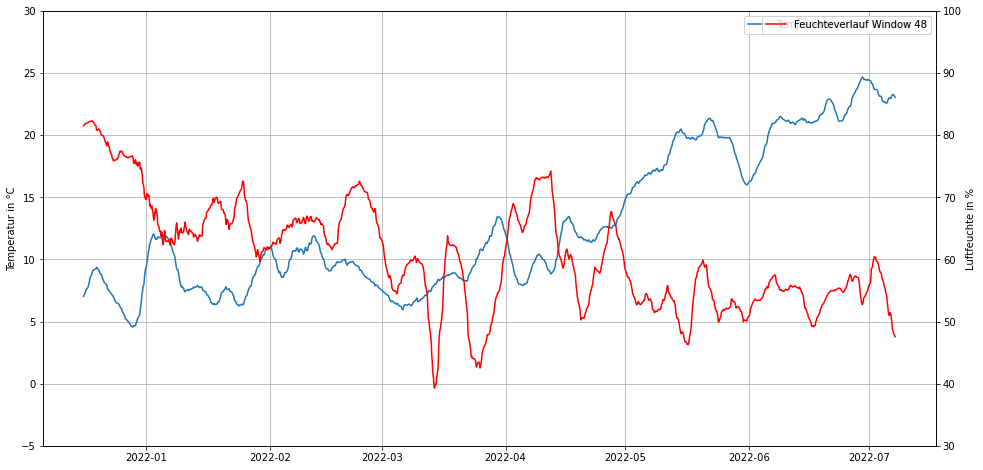

In [157]:
plotdata = data

h = plt.figure(figsize=(16, 8))
h.gca().grid()

plt.plot(plotdata.index,plotdata.Temperature.rolling(48).mean(),'-', label="Temperaturverlauf Window 48")
plt.legend()

ax1 = h.gca()
ax1.set_ylabel('Temperatur in °C')
ax2 = ax1.twinx()
ax2.set_ylabel('Luftfeuchte in %')
ax2.set_ylim(30, 100)
ax1.set_ylim(-5, 30) #grid gleich halten
ax2.plot(plotdata.index,plotdata.Humidity.rolling(48).mean(),'r-', label="Feuchteverlauf Window 48")
ax2.legend()

### Typ. Tagestemperaturverlauf im Juni

(15.0, 30.0)

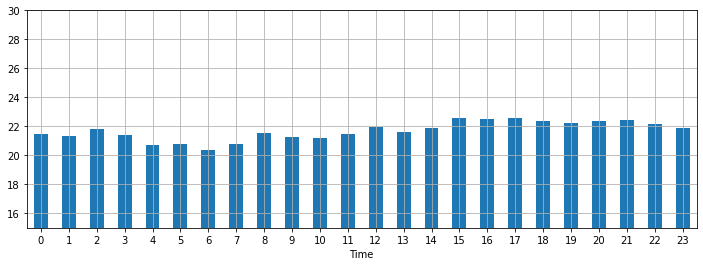

In [139]:
plotdata = data["2022-06-01":"2022-06-30"]
plotdata = plotdata.reset_index()
fig, axs = plt.subplots(figsize=(12, 4))
plotdata.groupby(plotdata["Time"].dt.hour)["Temperature"].mean().plot(kind='bar', rot=0, ax=axs)
axs.grid()
axs.set_ylim(15,30)


## Datenbankverbindung beenden

c.close()
conn.close()